In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 61.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=accf0920791570e8f9c7ec9a839051695762b672d9b0a268065fab77f9bc0012
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import requests 
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import functions as F

In [3]:
spark = pyspark.sql.SparkSession \
    .builder \
    .appName("DS_test") \
    .getOrCreate()

In [4]:
file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt'
file_path = "/content/USCensus1990.data.txt"

r = requests.get(file_url, stream = True) 

with open( file_path, "wb") as file: 
    for block in r.iter_content(chunk_size = 1024*10): 
        if block: 
            file.write(block)

In [5]:
data = spark.read.text("/content/USCensus1990.data.txt")

In [6]:
rows = data.selectExpr("split(value, ' ') as Text_Data_In_Rows_Using_Text")
rows_ = rows.select("Text_Data_In_Rows_Using_Text").rdd.flatMap(lambda x: x).collect()

In [7]:
rows_[0]

['caseid,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,iEnglish,iFeb55,iFertil,dHispanic,dHour89,dHours,iImmigr,dIncome1,dIncome2,dIncome3,dIncome4,dIncome5,dIncome6,dIncome7,dIncome8,dIndustry,iKorean,iLang1,iLooking,iMarital,iMay75880,iMeans,iMilitary,iMobility,iMobillim,dOccup,iOthrserv,iPerscare,dPOB,dPoverty,dPwgt1,iRagechld,dRearning,iRelat1,iRelat2,iRemplpar,iRiders,iRlabor,iRownchld,dRpincome,iRPOB,iRrelchld,iRspouse,iRvetserv,iSchool,iSept80,iSex,iSubfam1,iSubfam2,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv']

In [8]:
len(rows_)

2458286

In [9]:
rdd = spark.sparkContext.parallelize([[int(j) for j in i[0].split(',')] for i in rows_[1:100]])
df = rdd.toDF(rows_[0][0].split(','))
df.printSchema()

root
 |-- caseid: long (nullable = true)
 |-- dAge: long (nullable = true)
 |-- dAncstry1: long (nullable = true)
 |-- dAncstry2: long (nullable = true)
 |-- iAvail: long (nullable = true)
 |-- iCitizen: long (nullable = true)
 |-- iClass: long (nullable = true)
 |-- dDepart: long (nullable = true)
 |-- iDisabl1: long (nullable = true)
 |-- iDisabl2: long (nullable = true)
 |-- iEnglish: long (nullable = true)
 |-- iFeb55: long (nullable = true)
 |-- iFertil: long (nullable = true)
 |-- dHispanic: long (nullable = true)
 |-- dHour89: long (nullable = true)
 |-- dHours: long (nullable = true)
 |-- iImmigr: long (nullable = true)
 |-- dIncome1: long (nullable = true)
 |-- dIncome2: long (nullable = true)
 |-- dIncome3: long (nullable = true)
 |-- dIncome4: long (nullable = true)
 |-- dIncome5: long (nullable = true)
 |-- dIncome6: long (nullable = true)
 |-- dIncome7: long (nullable = true)
 |-- dIncome8: long (nullable = true)
 |-- dIndustry: long (nullable = true)
 |-- iKorean: long (n

In [10]:
df.show(2)

+------+----+---------+---------+------+--------+------+-------+--------+--------+--------+------+-------+---------+-------+------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------+-------+------+--------+--------+---------+------+---------+---------+---------+------+---------+---------+----+--------+------+---------+---------+-------+-------+---------+-------+-------+---------+---------+-----+---------+--------+---------+-------+-------+----+--------+--------+---------+---------+--------+-------+-------+--------+-----+--------+--------+--------+
|caseid|dAge|dAncstry1|dAncstry2|iAvail|iCitizen|iClass|dDepart|iDisabl1|iDisabl2|iEnglish|iFeb55|iFertil|dHispanic|dHour89|dHours|iImmigr|dIncome1|dIncome2|dIncome3|dIncome4|dIncome5|dIncome6|dIncome7|dIncome8|dIndustry|iKorean|iLang1|iLooking|iMarital|iMay75880|iMeans|iMilitary|iMobility|iMobillim|dOccup|iOthrserv|iPerscare|dPOB|dPoverty|dPwgt1|iRagechld|dRearning|iRelat1|iRelat2|iRemplpar|iRiders|iRla

In [11]:
num_rows = df.count()

In [12]:
num_rows

99

In [11]:
def get_null(df, plot=True):
  null_count = df.select([F.count(F.when(F.isnan(c)|F.col(c).isNull(),c)).alias(c) for c in df.columns]).collect()[0].asDict()
  null_rate = {k:v/num_rows for k, v in null_count.items() if v>int(num_rows/10)}  
  if plot:
    # print(f'The number of null values in each column: {null_count}')
    print(f'The percentage of null values in each column having null values: {null_rate}')
    fig = plt.figure(figsize=(20, 5))
    plt.bar(null_rate.keys(), null_rate.values())
    plt.ylabel('Null')
    plt.xticks(rotation = 60)
    plt.show()
  return null_rate

The percentage of null values in each column having null values: {}


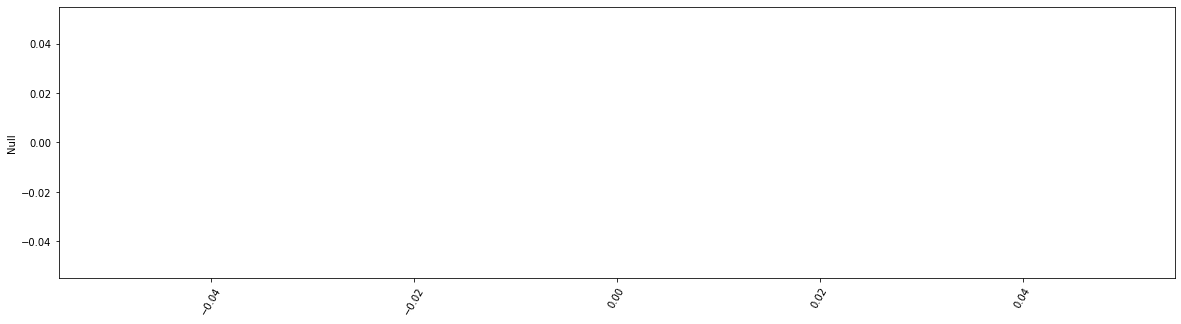

In [15]:
null_rate = get_null(df)

In [12]:
def get_distinct_values(df, plot=True):
  distinct_count = df.select([F.countDistinct(c).alias(c) for c in df.columns]).collect()[0].asDict()
  if plot:
    print(f'The number of distinct values in each column: {distinct_count}')
  return distinct_count

In [17]:
distinct_count = get_distinct_values(df)

The number of distinct values in each column: {'caseid': 99, 'dAge': 7, 'dAncstry1': 8, 'dAncstry2': 4, 'iAvail': 3, 'iCitizen': 3, 'iClass': 8, 'dDepart': 6, 'iDisabl1': 3, 'iDisabl2': 3, 'iEnglish': 4, 'iFeb55': 2, 'iFertil': 8, 'dHispanic': 2, 'dHour89': 6, 'dHours': 6, 'iImmigr': 5, 'dIncome1': 4, 'dIncome2': 2, 'dIncome3': 2, 'dIncome4': 2, 'dIncome5': 2, 'dIncome6': 2, 'dIncome7': 2, 'dIncome8': 2, 'dIndustry': 10, 'iKorean': 2, 'iLang1': 3, 'iLooking': 3, 'iMarital': 5, 'iMay75880': 2, 'iMeans': 6, 'iMilitary': 4, 'iMobility': 3, 'iMobillim': 3, 'dOccup': 7, 'iOthrserv': 1, 'iPerscare': 3, 'dPOB': 4, 'dPoverty': 3, 'dPwgt1': 4, 'iRagechld': 5, 'dRearning': 5, 'iRelat1': 11, 'iRelat2': 2, 'iRemplpar': 7, 'iRiders': 5, 'iRlabor': 4, 'iRownchld': 2, 'dRpincome': 5, 'iRPOB': 7, 'iRrelchld': 2, 'iRspouse': 7, 'iRvetserv': 7, 'iSchool': 4, 'iSept80': 2, 'iSex': 2, 'iSubfam1': 2, 'iSubfam2': 2, 'iTmpabsnt': 3, 'dTravtime': 7, 'iVietnam': 2, 'dWeek89': 3, 'iWork89': 3, 'iWorklwk': 3, 'i

In [ ]:
df.dtypes

In [55]:
def get_numerical_or_categorical_columns(df, plot=True):
  num_rows = df.count()
  distinct_count = get_distinct_values(df, False)

  numerical_type = ['float', 'double']
  int_categorical_type = ['int', 'long', 'bigint']
  other_categorical_type = ['string', 'datetime', 'bool']

  numeric_cols = [col[0] for col in df.dtypes if col[1] in numerical_type or (col[1] in int_categorical_type and distinct_count[col[0]]>20 and distinct_count[col[0]]<num_rows)]
  int_cate_cols = [col[0] for col in df.dtypes if col[1] in int_categorical_type and distinct_count[col[0]]<=20 and distinct_count[col[0]]<num_rows]
  other_cates_cols = [col[0] for col in df.dtypes if col[1] not in numerical_type and col[1] not in int_categorical_type and distinct_count[col[0]]<num_rows]

  if plot:
    print(f'Numerical columns: {numeric_cols}')
    print(f'Integer Categorical columns: {int_cate_cols}')
    print(f'Other Categorical columns: {other_cates_cols}')
  return numeric_cols, int_cate_cols, other_cates_cols

In [22]:
numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df)

Numerical columns: []
Integer Categorical columns: []
Other Categorical columns: ['dAge', 'dAncstry1', 'dAncstry2', 'iAvail', 'iCitizen', 'iClass', 'dDepart', 'iDisabl1', 'iDisabl2', 'iEnglish', 'iFeb55', 'iFertil', 'dHispanic', 'dHour89', 'dHours', 'iImmigr', 'dIncome1', 'dIncome2', 'dIncome3', 'dIncome4', 'dIncome5', 'dIncome6', 'dIncome7', 'dIncome8', 'dIndustry', 'iKorean', 'iLang1', 'iLooking', 'iMarital', 'iMay75880', 'iMeans', 'iMilitary', 'iMobility', 'iMobillim', 'dOccup', 'iOthrserv', 'iPerscare', 'dPOB', 'dPoverty', 'dPwgt1', 'iRagechld', 'dRearning', 'iRelat1', 'iRelat2', 'iRemplpar', 'iRiders', 'iRlabor', 'iRownchld', 'dRpincome', 'iRPOB', 'iRrelchld', 'iRspouse', 'iRvetserv', 'iSchool', 'iSept80', 'iSex', 'iSubfam1', 'iSubfam2', 'iTmpabsnt', 'dTravtime', 'iVietnam', 'dWeek89', 'iWork89', 'iWorklwk', 'iWWII', 'iYearsch', 'iYearwrk', 'dYrsserv']


In [14]:
def get_distribution(df, plot=True):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    all_columns = numeric_cols+int_cate_cols
    describe = df.select(all_columns).describe().toPandas().to_dict('list')
    quantitle = {c:df.approxQuantile(c, [0.25, 0.5, 0.75], 0) for c in all_columns}.collect()[0].asDict()

    if plot:
        for e, c in enumerate(all_columns):
            print(c, end='; ')
            print(f"Count: {describe[c][0]}", end='; ')
            print(f"Mean: {describe[c][1]}", end='; ')
            print(f"Std: {describe[c][2]}", end='; ')
            print(f"min: {describe[c][3]}", end='; ')
            print(f"max: {describe[c][4]}", end='; ')
            print(f"median: {quantitle[c][1]}", end='; ')
            print(f"25%: {quantitle[c][0]}", end='; ')
            print(f"50%: {quantitle[c][1]}", end='; ')
            print(f"75%: {quantitle[c][2]}")

    return describe, quantitle

In [15]:
def get_existing_times_of_values(df):
    num_rows = df.count()
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    cate_cols = int_cate_cols+other_cates_cols
    count_columns = {c:df.groupby(c).agg(F.count()/num_rows) for i in cate_cols}

    for c in count_columns:
        fig = plt.figure(figsize=(20, 5))
        plt.bar(count_columns[c].keys(), count_columns[c].values())
        plt.title(f'Column {c}')
        plt.xlable(f'Values in column {c}')
        plt.ylabel(f'Existing times of values in column {c}')
        plt.xticks(rotation = 60)
        plt.show()
    
    return count_columns

In [17]:
def get_most_popular_and_least_popular_values(df):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    all_columns = numeric_cols+int_cate_cols+other_cates_cols
    most_popular_values = {c:sorted({v[c]:v['count'] for v in df.groupby(c).count().toPandas().to_dict('record')}.items(), key=lambda x:x[1], reverse=True)[0] for c in all_columns}
    least_popular_values = {c:sorted({v[c]:v['count'] for v in df.groupby(c).count().toPandas().to_dict('record')}.items(), key=lambda x:x[1])[0] for c in all_columns}
    return most_popular_values, least_popular_values


In [18]:
def find_outliers_by_boxplot(df, plot):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    all_columns = numeric_cols+int_cate_cols
    describe, quantitle = get_distribution(df, plot=False)
    outliers_of_cols = {}
    for c in all_columns:
        values = np.array(df.select(c).rdd.flatMap(lambda x:x).collect())
        iqr = quantitle[c][2] - quantitle[c][0]
        upper_bound = quantitle[c][2]+1.5*iqr
        lower_bound = quantitle[c][0]-1.5*iqr

        outliers = values[(values <= lower_bound)|(values >= upper_bound)]
        outliers_of_cols[c] = outliers
        
        if plot:
            plt.boxplot(values)
            plt.title(f'Column {c}')
            plt.show()
            print(f"Outliers: {outliers}")
    return 

def find_outliers_by_histogram(df):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    distinct_count = get_distinct_values(df, False)
    for c in numeric_cols:
        values = df.select(c).rdd.flatMap(lambda x: x).collect()
        plt.hist(values, int(1 + 3.322*log(distinct_count[c])))
        plt.title(f'Column: {c}')
        plt.show()


In [89]:
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import VectorAssembler

def get_correlation(df):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=int_cate_cols, 
                                outputCol=vector_col)
    myGraph_vector = assembler.transform(df.select(int_cate_cols)).select(vector_col)
    pearsonCorr = Correlation.corr(myGraph_vector, vector_col, "pearson").collect()[0][0].toArray().tolist()
    # spearmanCorr = Correlation.corr(df.select(int_cate_cols), df.columns[0],'spearman').collect()[0][0]
    fig=plt.figure(200)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+int_cate_cols)
    ax.set_yticklabels(['']+int_cate_cols)
    cax=ax.matshow(pearsonCorr,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
    sns.heatmap(pearsonCorr)

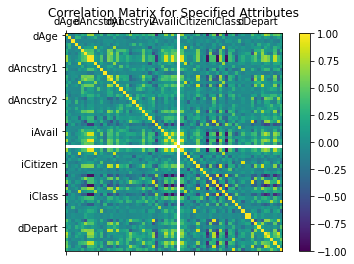

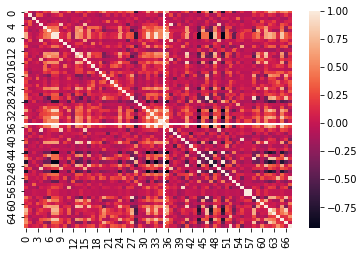

In [90]:
get_correlation(df)

In [97]:
from pyspark.ml.feature import StringIndexer
def get_chi_square(df):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    chi_square = {}
    for c in int_cate_cols+other_cates_cols:
      assembler = VectorAssembler().setInputCols([c]).setOutputCol("features")
      chi_square[c] = ChiSquareTest.test(assembler.transform(df), "features", int_cate_cols[0]).collect()[0]
    return chi_square

In [ ]:
get_chi_square(df)

In [ ]:
numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
chi_square = {}
for c in int_cate_cols+other_cates_cols:
    assembler = VectorAssembler().setInputCols([c]).setOutputCol("features")
    chi_square[c] = ChiSquareTest.test(assembler.transform(df), "features", int_cate_cols[0]).collect()[0]

In [ ]:
# df = spark.createDataFrame(data, ['feature1', 'feature2'])
chi_square

In [153]:
from pyspark.sql.functions import lit, avg, count, udf, struct, sum
from pyspark.sql.types import DoubleType

def one_way_anova(df, categorical_var, continuous_var):
    """
    Given a Spark Dataframe, compute the one-way ANOVA using the given categorical and continuous variables.
    :param df: Spark Dataframe
    :param categorical_var: Name of the column that represents the grouping variable to use
    :param continuous_var: Name of the column corresponding the continuous variable to analyse
    :return: Sum of squares within groups, Sum of squares between groups, F-statistic, degrees of freedom 1, degrees of freedom 2
    """

    global_avg = df.select(avg(continuous_var)).take(1)[0][0]

    avg_in_groups = df.groupby(categorical_var).agg(avg(continuous_var).alias("Group_avg"),
                                                    count("*").alias("N_of_records_per_group"))
    avg_in_groups = avg_in_groups.withColumn("Global_avg",
                                            lit(global_avg))

    udf_between_ss = udf(lambda x: x[0] * (x[1] - x[2]) ** 2,
                        DoubleType())
    between_df = avg_in_groups.withColumn("squared_diff",
                                        udf_between_ss(struct('N_of_records_per_group',
                                                                'Global_avg',
                                                                'Group_avg')))
    ssbg = between_df.select(sum('squared_diff')).take(1)[0][0]

    within_df_joined = avg_in_groups \
        .join(df,
            df[categorical_var] == avg_in_groups[categorical_var]) \
        .drop(avg_in_groups[categorical_var])

    udf_within_ss = udf(lambda x: (x[0] - x[1]) ** 2, DoubleType())
    within_df_joined = within_df_joined.withColumn("squared_diff",
                                                udf_within_ss(struct(continuous_var,
                                                                        'Group_avg')))
    sswg = within_df_joined \
        .groupby(categorical_var) \
        .agg(sum("squared_diff").alias("sum_of_squares_within_gropus")) \
        .select(sum('sum_of_squares_within_gropus')).take(1)[0][0]
    m = df.groupby(categorical_var) \
        .agg(count("*")) \
        .count()  # number of levels
    n = df.count()  # number of observations
    df1 = m - 1
    df2 = n - m
    f_statistic = (ssbg / df1) / (sswg / df2)
    return sswg, ssbg, f_statistic, df1, df2

In [160]:
def anova(df, label='label'):
    numeric_cols, int_cate_cols, other_cates_cols = get_numerical_or_categorical_columns(df, False)
    anova_2_cols = {}
    for c in int_cate_cols:
        anova_2_cols[c] = one_way_anova(df, c, 'caseid')
        print(anova_2_cols)
    return anova_2_cols

In [161]:
anova(df)

{'dAge': (75997.74061355312, 4852.259386446903, 0.9789937173331891, 6, 92)}
{'dAge': (75997.74061355312, 4852.259386446903, 0.9789937173331891, 6, 92), 'dAncstry1': (77684.48181818186, 3165.5181818181763, 0.5297291737100167, 7, 91)}
{'dAge': (75997.74061355312, 4852.259386446903, 0.9789937173331891, 6, 92), 'dAncstry1': (77684.48181818186, 3165.5181818181763, 0.5297291737100167, 7, 91), 'dAncstry2': (80534.91202475686, 315.0879752432909, 0.12389391919416248, 3, 95)}
{'dAge': (75997.74061355312, 4852.259386446903, 0.9789937173331891, 6, 92), 'dAncstry1': (77684.48181818186, 3165.5181818181763, 0.5297291737100167, 7, 91), 'dAncstry2': (80534.91202475686, 315.0879752432909, 0.12389391919416248, 3, 95), 'iAvail': (79799.83333333342, 1050.1666666666908, 0.6316805172943274, 2, 96)}


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored